In [2]:
import os
import pickle as pkl
from datetime import datetime
from tqdm.auto import tqdm, trange
%load_ext autoreload
%autoreload 2
randint = np.random.randint

print('Starting')

model_fname = 'temp/net_worker.dat'
fnmask = 'temp/selfplay_%d.dat'

    

from hex_net13x13 import *
net = Net13x13()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting


In [6]:
## Fake net
##torch.save(net.state_dict(), model_fname)

In [104]:

from collections import namedtuple

gamestate = namedtuple('gamestate', 'b, p, vd, v, addv, endb', defaults=[None, None, None, 0, [], None])
# p=board, p=policy, vd=valid mask, v=winner, addv=additional values, endb=end board

def split(l, k):
    # splits a list at place k
    return l[:k], l[k:]

In [158]:

N = 13
bsize = 13


def newboard():
    part = np.random.rand()
    while True:
        board = filledboard(bsize, part)
        if not winner(board):
            return board
        part *= .99 # avoid infinite loop
        
        
def selfplay_batched(app, exp, ngames=1000000, verbose=1):
    
    bnum = app.nparallel
    global game_records
    game_records = []
    
    exp.eta = 0.3
    
    # Iterator with tqdm??
    if verbose>=1:
        pbar = tqdm(total=ngames)
        
    #newboard = lambda: filledboard(bsize, count=3)
    boards = [ newboard() for _ in range(bnum) ]
    turns = [ getturn(brd) for brd in boards ]
    records = [ [] for _ in range(bnum) ]
    
    expert_queue = [] # queue for expert to build full mctree for states
    
    ncompleted = 0
    while ncompleted < ngames:
        
        check_new_model(net)
        
        moves = app.findmove(boards)
        for b in range(bnum):
            turn = turns[b]
            x, y = moves[b]
            valid = (boards[b]==0)
            policy = app.mcts[b].policy
            records[b] += [(boards[b].copy(), policy, valid, turn)] if turn > 0 else \
                          [(-boards[b].T.copy(), policy.T, valid.T, turn)]
            boards[b][x, y] = turns[b]
            turns[b] *= -1
            app.mcts[b].clear()
            
            won = winner(boards[b])
            if won:
                game_records += [ gamestate(b=b, p=p, vd=vd, v=t*won, endb=boards[b]) for (b, p, vd, t) in records[b][randint(app_modulo)::app_modulo] ] # not all game states
                expert_queue += [ records[b][i][0] for i in (np.random.choice(range(len(records[b])), expert_states_per_game) if len(records[b]) > 5*expert_state_per_game \
                                                                        else range(0, len(records[b]), 5)) ]  # schöner machen
                # Flush if big enough
                if len(game_records) > 500:
                    try:
                        save_records(game_records)
                        game_records = []
                    except:
                        print('Couldnt save records!')
                
                ncompleted += 1
                records[b] = []
                boards[b] = newboard()
                turns[b] = getturn(boards[b])
                if verbose>=1:
                    pbar.update(1)
                    
        # Expert queue checken
        if len(expert_queue) >= exp.nparallel:
            print('Expert tree building')
            expboards, expert_queue = split(expert_queue, exp.nparallel)
            exp.findmove(expboards)
            for b in range(exp.nparallel):
                policy = exp.mcts[b].policy
                valid = (expboards[b]==0)
                turn = getturn(expboards[b])
                addv_rollout = np.mean([ rollout(s) for s in exp.mcts[b].states.values() ])
                addv_dijkstra = np.mean([ heuristic_dijkstra(s) for s in exp.mcts[b].states.values() ])
                addv_netoutputs = np.mean([ v for v in exp.mcts[b].v.values() ], axis=0)
                addv = np.concatenate([[addv_rollout], [addv_dijkstra], addv_netoutputs[:2]])
                print(addv)
                game_records += [ gamestate(b=expboards[b],   p=policy,   vd=valid,   v=None, addv=[addv_rollout]) ] if turn > 0 else \
                                [ gamestate(b=expboards[b].T, p=policy.T, vd=valid.T, v=None, addv=[addv_rollout]) ]
                exp.mcts[b].clear()
            
    
    if verbose>=1:
        pbar.close()
        
    return game_records


In [159]:
# Für app vll 10 searches nehmen, useQ und negcp? ohne cuncert?
# für exp 1000 wie im paper ('thinking fast and slow'), dafür schnick schnack
# wie useQ und negCP weglassen sowie cuncert

from hex_heuristics import *

exp_modulo=1
exp_savemoves = True
exp_nparallel=50
exp_nsearches=150
#exp_nsearches=300

exp_params={'negCP': 1,
         'useQ': True,
         'cuncert': 4,
         'eta': .2}

expert_states_per_game = 10
    
app_modulo=20
app_savemoves = False
app_nparallel=50
app_nsearches=1
    
app_params={'negCP': .1,
         'useQ': True,
         'cuncert': 0,
         'eta': .0}


print('Starting Selfplay')
print('Expert:')
print('nparallel =', exp_nparallel)
print('nsearches =', exp_nsearches)
print('params =',    exp_params)
print('modulo =',    exp_modulo)
print()
print('Apprentice:')
print('nparallel =', app_nparallel)
print('nsearches =', app_nsearches)
print('params =',    app_params)
print('modulo =',    app_modulo)
print('Expert states per game =', expert_states_per_game)





exp = BatchMCTS(exp_nparallel, exp_nsearches, net=net, params=exp_params)
app = BatchMCTS(app_nparallel, app_nsearches, net=net, params=app_params)

selfplay_batched(app, exp)

Starting Selfplay
Expert:
nparallel = 50
nsearches = 150
params = {'negCP': 1, 'useQ': True, 'cuncert': 4, 'eta': 0.2}
modulo = 1

Apprentice:
nparallel = 50
nsearches = 1
params = {'negCP': 0.1, 'useQ': True, 'cuncert': 0, 'eta': 0.0}
modulo = 20


Couldnt load new model parameters at time 01:39:17!
Couldnt load new model parameters at time 01:39:18!
Couldnt load new model parameters at time 01:39:19!
Couldnt load new model parameters at time 01:39:19!



Couldnt load new model parameters at time 01:39:20!
Couldnt load new model parameters at time 01:39:21!
Couldnt load new model parameters at time 01:39:22!
Couldnt load new model parameters at time 01:39:22!
Couldnt load new model parameters at time 01:39:23!
Couldnt load new model parameters at time 01:39:24!
Couldnt load new model parameters at time 01:39:24!
Couldnt load new model parameters at time 01:39:25!
Couldnt load new model parameters at time 01:39:26!
Couldnt load new model parameters at time 01:39:27!
Expert tree building
[-0.96923077  0.88217278  0.02176327  0.02885377]
[ 0.95428571 -0.87251547  0.02251137  0.02703802]
[ 0.95       -0.87952473  0.02251645  0.02699737]
[-0.97837838  0.88447738  0.02182847  0.02889503]
[ 0.93333333 -0.87414309  0.02251715  0.02706266

[-0.88609272  0.56864318  0.0221932   0.03017479]
[-0.47916667  0.51843006  0.02025305  0.02972044]
[-0.12847682 -0.24020329  0.02142107  0.02937081]
[-0.09933775  0.02475277  0.02154987  0.02998692]
[-0.27218045  0.35856528  0.0212774   0.02990862]
[ 0.18666667 -0.3011182   0.02162215  0.03041764]
[-0.16571429  0.14285714  0.02135142  0.02768166]
[-0.33809524  0.36592943  0.02150673  0.02839264]
[0.08874172 0.23208535 0.01967299 0.03188482]
[ 0.19205298 -0.3029085   0.02065753  0.03067025]
[-0.22649007  0.04399252  0.02043815  0.03076507]
[-0.2244898   0.33535942  0.02169474  0.02902784]
[-0.10967742  0.12903226  0.02267078  0.03073457]
[-0.47027027  0.33985023  0.02230048  0.0286695 ]
[-0.28372093  0.33729151  0.02249078  0.02815182]
[-0.35555556  0.34035961  0.02108339  0.02874057]
[ 0.21904762 -0.32235707  0.02121029  0.02999148]
[-0.34285714  0.3376672   0.02275034  0.02769736]
[ 0.24       -0.33847492  0.02113459  0.03039716]
[-0.4         0.34035961  0.02259383  0.02897511]
[ 0.

[-0.55761589  0.31207656  0.02240727  0.02758992]
[ 0.47284768 -0.25670804  0.02068634  0.03133165]
[-0.61589404  0.30355967  0.02277665  0.02811116]
[-0.48344371  0.53885054  0.02191884  0.02837274]
[ 0.45165563 -0.29357703  0.02025318  0.03123235]
[-0.59470199  0.33336879  0.02153508  0.02770891]
[ 0.40927152 -0.45990866  0.02124065  0.03214959]
[ 0.51258278 -0.24872454  0.02026108  0.03164103]
[ 0.53907285 -0.38161798  0.02145871  0.03152216]
[ 0.51515152 -0.34314756  0.02321199  0.03073307]
[ 0.11788079 -0.32151709  0.01949324  0.03151357]
[ 0.33245033 -0.34172985  0.02060995  0.0318642 ]
[-0.45945946  0.26260286  0.02219409  0.0295788 ]
[ 0.46666667 -0.35630696  0.02444895  0.03038504]
[ 0.61142857 -0.34191128  0.02368658  0.03041854]
[-0.17615894  0.24512957  0.0194405   0.03137944]
[-0.56821192  0.37870353  0.01930535  0.03153806]
[-0.6         0.28211171  0.02219583  0.029518  ]
[-0.02439024 -0.02439024  0.02262052  0.02995466]
[-0.05        0.          0.02260069  0.02994208]


[-0.77218543  0.92722524  0.02189982  0.03553255]
[ 0.67417219 -0.92731641  0.02168636  0.02940642]
[ 0.75629139 -0.9237028   0.02222326  0.02972632]
[-0.79602649  0.76157328  0.02155988  0.03402743]
[ 0.55496689 -0.93101844  0.02333891  0.03053622]
Couldnt load new model parameters at time 01:41:47!
Couldnt load new model parameters at time 01:41:48!
Couldnt load new model parameters at time 01:41:48!
Couldnt load new model parameters at time 01:41:49!
Saved 505 boards to temp/selfplay_8.dat.
Expert tree building
[ 0.19205298 -0.0512358   0.02005032  0.03219555]
[-0.17086093  0.08184284  0.02051027  0.03384442]
[-0.14966887  0.31858996  0.020708    0.03404007]
[ 0.46754967 -0.71620765  0.02136706  0.03631436]
[ 0.02857143 -0.02857143  0.02102782  0.03104916]
[-0.33774834  0.54990789  0.02077988  0.03235892]
[-0.14172185  0.55546672  0.02169062  0.03406042]
[-0.16821192  0.05842138  0.02050889  0.03379862]
[-0.06490066 -0.01104507  0.0209326   0.03337103]
[-0.18940397  0.02688199  0.01

[-0.07428571 -0.02857143  0.0236483   0.0285124 ]
[ 0.26666667 -0.29166667  0.02372633  0.0314193 ]
[0.05365854 0.         0.02363987 0.02853722]
[-0.02105263  0.          0.02365367  0.02852604]
[ 0.3        -0.29166667  0.02372632  0.0314193 ]
[ 0.23333333 -0.29166667  0.02372633  0.0314193 ]
Couldnt load new model parameters at time 01:42:38!
Couldnt load new model parameters at time 01:42:38!
Couldnt load new model parameters at time 01:42:39!
Couldnt load new model parameters at time 01:42:40!
Couldnt load new model parameters at time 01:42:40!
Couldnt load new model parameters at time 01:42:41!


KeyboardInterrupt: 

In [ ]:
# Gegeben: mcts nach tree search (d. h. findmove wurde ausgeführt)
# Will: Mittelung der Baumes über heuristic wie rollout oder dijkstra (Funktion heuristic: state -> h)
# Anmerkung: h ist hier generischer Buchstabe für den heuristischen Wert

hs = []
for state in mcts.states.values():
    hs.append(heuristic(state))
    
h_mean = np.mean(hs)


# das geht vereinfacht:

h_mean = np.mean([ heuristic(s) for s in mcts.states.values() ])


# ganz konkret:

h_dijkstra = np.mean([ dijkstra_heuristic(s) for s in mcts.states.values() ])
h_rollout = np.mean([ rollout(s) for s in mcts.states.values() ])

In [24]:
import scipy.sparse

def resistance_new(board):
    N = len(board)
    r = 1e-5*(board==+1) + 1.*(board==0) + 9999999999999*(board==-1)
    
    def I_ind(i,j,d):
        return (i*N+j)*3+d
    
    X = 123
    M = scipy.sparse.coo_matrix((3*(N-1)**2 + X, 3*(N-1)**2 + X))
    c = np.zeros(3*(N-1)**2 + X)
    
    for i in range((N-1)**2):
        for j in range((N-1)**2):
            # Masche unteres Dreieck
            M[] = 

In [9]:
# WICHTIG für Heuristik mit Widerstand!

def resistance(board):
    'Given: board NxN'
    'Returns: Resistance of the network'
    N = len(board)
    r = 1e-5*(board==+1) + 1.*(board==0) + 9999999999999*(board==-1)

    relatives = [(0,1), (1,0), (-1, 1), (0,-1), (-1,0), (1,-1)]
    
    global M, c
    
    def exists(k, a): # Checkt, ob der nachbar a = 0..5 im Brett ist
        assert a in [0,1,2,3,4,5]
        i,j = divmod(k,N)
        di, dj = relatives[a]
        return 0<=i+di<N and 0<=j+dj<N
    def neighbour(k, a):
        i,j = divmod(k,N)
        di, dj = relatives[a]
        return N*(i+di) + (j+dj)
    def sign(a): # vorzeichen eines Kanten des gerichteten graphen
        return +1 if a < 3 else -1
    def R(k, a): # Widerstand von Kanten k zu seinem nachbarn a=0..5
        i,j = divmod(k,N)
        di, dj = relatives[a]
        return (r[i,j] + r[i+di,j+dj]) / 2
    
    U_ind = {k: k for k in range(N**2)}
    I_ind = {}
    neighbours = { k: [] for k in range(N**2)}
    i = N**2
    for k in range(N**2):
        for a in range(3):
            if not exists(k,a):
                continue
            k2 = neighbour(k,a)
            I_ind[k,k2] = i
            I_ind[k2,k] = i
            i += 1
            neighbours[k] += [k2]
            neighbours[k2] += [k]
    for k in range(N):
        I_ind['s',k] = i
        i += 1
        I_ind['t',k] = i
        i += 1
    U_ind['s'] = i
    i += 1
    U_ind['t'] = i
    i += 1

    ##print(i, 'Variable')
    
    num1 = N**2
    num2 = (N-1)*(3*N-1)
    num = num1+num2
    M, c = np.zeros((99*num, 9*num)), np.zeros(99*num)
    
        

    l = 0
    
    # Knoten im Brett
    for k in range(N**2):
        # Knoten durchgehen, an jedem Knoten ist die Summe der Ströme null (eine Gleichung pro Knoten)
        for a in range(6):
            if not exists(k,a):
                continue
            k2 = neighbour(k,a)
            M[l, I_ind[k,k2]] = sign(a)
            c[l] = 0
        # wires to source and target
        if k//N == 0:
            M[l, I_ind['s', k%N]] = 1
        if k//N == (N-1):
            M[l, I_ind['t', k%N]] = -1
            
        l += 1
        
        
    for k in range(N**2):
        # Knoten durchgehen, für jeden Kanten ist die Spannungsabfall proportional zu Widerstand mal Strom
        for a in range(3): # Kanten nur einmal abhandeln, also positives vorzeichen nehmen
            # U_1 - U_2 = R_12 * I_12
            # 0 = U_1 - U_2 - R_12 * I_12
            if not exists(k,a): # kanten nicht vorhanden -> keine gleichung
                continue
            k2 = neighbour(k,a)
            M[l, U_ind[k]] = 1
            M[l, U_ind[k2]] = -1
            M[l, I_ind[k,k2]] = -R(k,a)
            c[l] = 0
            
            l += 1
            
    # Knoten souce und target mit Spannung ausstatten bzw. deren Verbindungen zum Feld
    for j in range(N):
        k2 = 0*N + j
        M[l, U_ind['s']] = -1
        M[l, U_ind[k2]]  = +1
        M[l, I_ind['s',j]] = -r[0,j]/2
        l += 1
        
        k = (N-1)*N + j
        M[l, U_ind[k]]   = -1
        M[l, U_ind['t']] = +1
        M[l, I_ind['t',j]] = -r[-1,j]/2
        l += 1
        
    # Spannungen an den Enden
    M[l, U_ind['s']] = 1
    c[l] = 0
    l += 1
    for k in range(N):
        M[l, I_ind['s', k]] = 1
    c[l] = -1 # 1A Quellstrom
    l += 1
        
    ##print(l, 'Gleichungen')
    M = M[:l,:l]
    c = c[:l]
    
    x = np.linalg.solve(M, c)
    del_U = abs(x[U_ind['t']])
        
    
    ##print(del_U)
    return del_U, x[:N**2]

In [4]:
board = np.ones((2,2))

M, c = resistance(board)
M.shape

()

In [5]:
x = np.linalg.solve(M, c)
x

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [66]:
M

array([[ 0.  ,  1.  , -1.  ,  0.  ,  0.  ],
       [ 1.  , -0.55,  0.  , -1.  ,  0.  ],
       [-1.  ,  0.  , -0.55,  0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  1.  ]])

In [95]:
board = -np.ones((3,3))
board[0,1] = 1
board[1,1] = 1
board[2,1] = 1
# Sollte widerstand 0 haben
resistance(board)

board = -np.ones((3,3))
board[0,1] = 1
board[1,1] = 1
board[2,1] = 0
# Sollte widerstand 1 haben
resistance(board)

board = -np.ones((3,3))
board[0,1] = 1
board[1,1] = 1
board[2,1] = 0
board[2,0] = 0
# Sollte widerstand < 1 und > 0 haben
resistance(board)


33 Variable
33 Gleichungen
-0.0
33 Variable
33 Gleichungen
0.9999999999998075
33 Variable
33 Gleichungen
0.49999999999997274


0.49999999999997274

The slowest run took 21.32 times longer than the fastest. This could mean that an intermediate result is being cached.
903 µs ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
20.7 ms ± 670 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


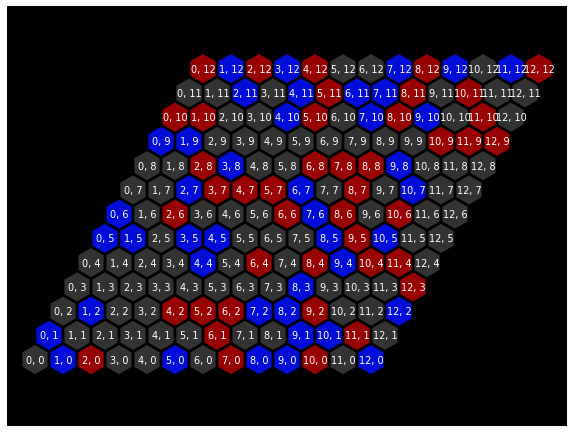

In [6]:
board = filledboard(13, .5)
show_board(board)


# dijkstra_dist
%timeit -n 100 dijkstra_dist(board.T)
%timeit -n 100 resistance(board)

In [22]:
import scipy.sparse.linalg
import scipy
Msp = scipy.sparse.coo_matrix(M)
csp = scipy.sparse.coo_matrix(c)
%timeit -n 100 scipy.sparse.linalg.spsolve(M, c)

5.88 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


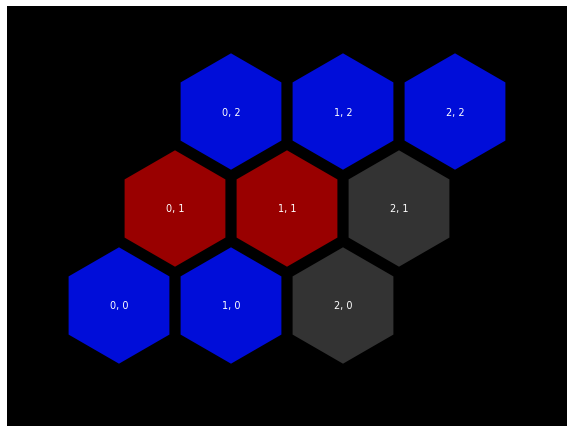

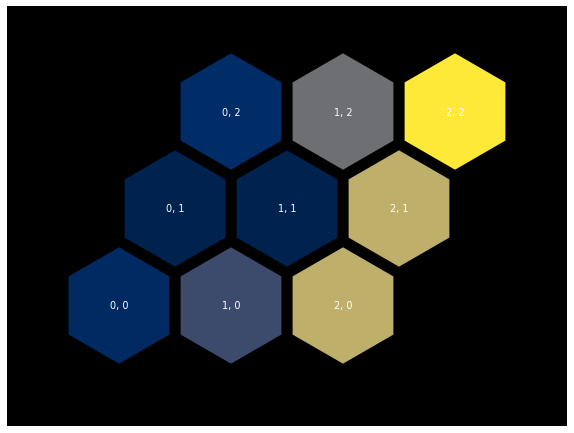

In [45]:

board = -np.ones((3,3))
board[0,1] = 1
board[1,1] = 1
board[2,1] = 0
board[2,0] = 0

show_board(board)
r, V = resistance(board)

Vp = V/V.min()
show_board(Vp.reshape((3,3)), cmap='cividis')

In [41]:
Vp

array([1.33583847e-06, 2.60456511e-06, 3.58178644e-06, 3.65012913e-06,
       1.87630793e-06, 9.38149285e-07, 3.68906955e-02, 2.35018516e-02,
       4.55313266e-06, 5.32679623e-03, 2.47452710e-03, 5.74800669e-07,
       5.21139533e-02, 4.00751540e-06, 5.59080538e-06, 7.16360871e-06,
       5.62894256e-06, 5.67177810e-02, 1.04915550e-01, 8.49042565e-02,
       1.30389699e-05, 2.57040252e-02, 9.09980858e-03, 2.89388579e-03,
       1.27993004e-01, 2.60567574e-01, 6.67919233e-06, 8.01504416e-06,
       7.84691104e-06, 5.91379965e-02, 2.01553688e-01, 1.91314631e-01,
       1.48274619e-01, 1.65465360e-01, 1.86887569e-01, 1.93428400e-01,
       2.61592926e-01, 3.87185138e-01, 4.69021196e-01, 8.65328955e-06,
       9.03463945e-06, 9.39232032e-06, 1.31509072e-01, 2.11792745e-01,
       2.45562356e-01, 2.53360895e-01, 3.65446296e-01, 3.65451939e-01,
       3.65456122e-01, 4.54514886e-01, 5.57029068e-01, 5.89466944e-01,
       1.08842823e-05, 5.54975484e-02, 9.51648520e-02, 1.85210221e-01,
      

In [1]:
from hex_helpers import *

In [86]:
board = filledboard(8, .2)

In [14]:
%timeit -n 100 board.tobytes()

235 ns ± 11.1 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [87]:
board

array([[ 0,  0,  0,  0,  0,  1, -1,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  1],
       [-1,  0,  0,  0,  0, -1,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0, -1,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, -1,  0,  0, -1],
       [ 0,  0,  0,  0,  0,  0,  1,  0]], dtype=int8)

In [98]:
from numba import njit
from numba.types import byte

@njit
def encode_boolean(arr):
    arr = arr.flatten()
    n = len(arr)
    m = (n)//8
    #print(n,m)
    h = np.zeros(m, byte)
    for i in range(m):
        for j in range(8):
            k = i*8+j
            if k > n:
                return h
            h[i] += arr[k] << j
    return h

def encode_board(board):
    return np.concatenate((encode_boolean(board==+1), encode_boolean(board==-1)))

In [104]:
%timeit -n 100 encode_board(board).tobytes()

25.5 µs ± 5.11 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [105]:
encode_board(board).tobytes()

b' \xa0\x00\x02\x84\x00\x00@@\x00!\x00@\x00\x90\x00'

In [106]:
board.tobytes()

b'\x00\x00\x00\x00\x00\x01\xff\x00\x00\x00\x00\x00\x00\x01\x00\x01\xff\x00\x00\x00\x00\xff\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\xff\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\x00\x00\xff\x00\x00\x00\x00\x00\x00\x01\x00'